In [1]:
## coding: utf-8

import numpy as np
import time
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F

from airbus_dataloader import *
from airbus_train_val_functions import *

import warnings
warnings.filterwarnings('ignore')

class Net2(nn.Module):
    def __init__(self):
        super(Net2, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16*45*45, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16*45*45)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


class CNN_32_x4(nn.Module):
    def __init__(self, num_classes):
        super(CNN_32_x4, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 32, 5) # input features, output features, kernel size
        self.act1 = nn.ReLU()
        self.mp1 = nn.MaxPool2d(2, 2) # kernel size, stride
        
        self.conv2 = nn.Conv2d(32, 64, 5) # input features, output features, kernel size
        self.act2 = nn.ReLU()
        self.mp2 = nn.MaxPool2d(2, 2) # kernel size, stride
        
        self.fc = nn.Linear(64*45*45, num_classes) # 4x4 is the remaining spatial resolution here

    def forward(self, x):
        x = self.mp1(self.act1(self.conv1(x)))
        x = self.mp2(self.act2(self.conv2(x)))
        # The view flattens the output to a vector (the representation needed by the classifier)
        x = x.view(-1, 64*45*45)
        x = self.fc(x)
        return x
    
class CNN_8_x4(nn.Module):
    def __init__(self, num_classes):
        super(CNN_8_x4, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 8, 5) # input features, output features, kernel size
        self.act1 = nn.ReLU()
        self.mp1 = nn.MaxPool2d(2, 2) # kernel size, stride
        
        self.conv2 = nn.Conv2d(8, 16, 5) # input features, output features, kernel size
        self.act2 = nn.ReLU()
        self.mp2 = nn.MaxPool2d(2, 2) # kernel size, stride
        
        self.fc = nn.Linear(16*45*45, num_classes) # 4x4 is the remaining spatial resolution here

    def forward(self, x):
        x = self.mp1(self.act1(self.conv1(x)))
        x = self.mp2(self.act2(self.conv2(x)))
        # The view flattens the output to a vector (the representation needed by the classifier)
        x = x.view(-1, 16*45*45)
        x = self.fc(x)
        return x


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
is_gpu = torch.cuda.is_available()
batch_size = 8
workers = 4
path = '../airbus/'
aug=False
resize_factor=4
empty_frac=1
test_size=0.1
    
dataset = AirbusDS(torch.cuda.is_available(), batch_size, workers, 
                   path, aug, resize_factor, empty_frac, test_size)

#model = CNN_8_x4(2).to(device)
model = torch.load('CNN_8_x4.model', map_location=device).to(device)

#predict(dataset.test_loader, model, device, predict_file='predictions04.txt', treshold=0.4)

In [2]:
root = '../airbus/'
real = pd.read_csv(str(root+'test_ship_segmentations.csv')).fillna(-1)
pred = pd.read_csv('predictions04.txt', delimiter='\t', names=['ImageId', 'Label']).fillna(-1)

In [3]:
comparison = pd.merge(real, pred, on='ImageId')
comparison.head()

ImageId                                      EncodedPixels  Label
0  0001124c7.jpg                                                 -1      1
1  000194a2d.jpg  51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...      1
2  000194a2d.jpg  360486 1 361252 4 362019 5 362785 8 363552 10 ...      1
3  000194a2d.jpg  254389 9 255157 17 255925 17 256693 17 257461 ...      1
4  000194a2d.jpg  198320 10 199088 10 199856 10 200624 10 201392...      1

In [7]:
#Losted ships
lost = comparison[(comparison['EncodedPixels']!=-1) & 
                  (comparison['Label']!=1)].count().values[0]

In [8]:
#Finded ships
found = comparison[(comparison['EncodedPixels']!=-1) & 
                   (comparison['Label']==1)].count().values[0]

In [9]:
#Ratio of declined images
decl = comparison[comparison['Label']!=1].count().values[0]/comparison.count().values[0]

In [10]:
print('We have lost {l} ships, but found {f}.'.format(l=lost, f=found))
print('So, we have lost {l:.2f}% ships.'.format(l=lost/(lost+found)*100))
print('But we have declined {d:.2f}% images.'.format(d=decl*100))

We have lost 1182 ships, but found 24511.
So, we have lost 4.60% ships.
But we have declined 34.84% images.


In [11]:
from torch.utils import data as D
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

class CustomDS(D.Dataset):
    def __init__(self, path, filenames):
        self.path = path
        self.filenames = filenames
        self.len = len(self.filenames)
        self.transform = transforms.ToTensor()
        
    def __getitem__(self, index):
        image = Image.open(str(self.path + self.filenames[index]))
        return self.transform(image)

    def __len__(self):
        return self.len

In [12]:
lost_list = comparison[(comparison['EncodedPixels']!=-1) & \
                       (comparison['Label']!=1)]['ImageId'].values

In [13]:
lost_ds = CustomDS('../airbus/test/', lost_list)

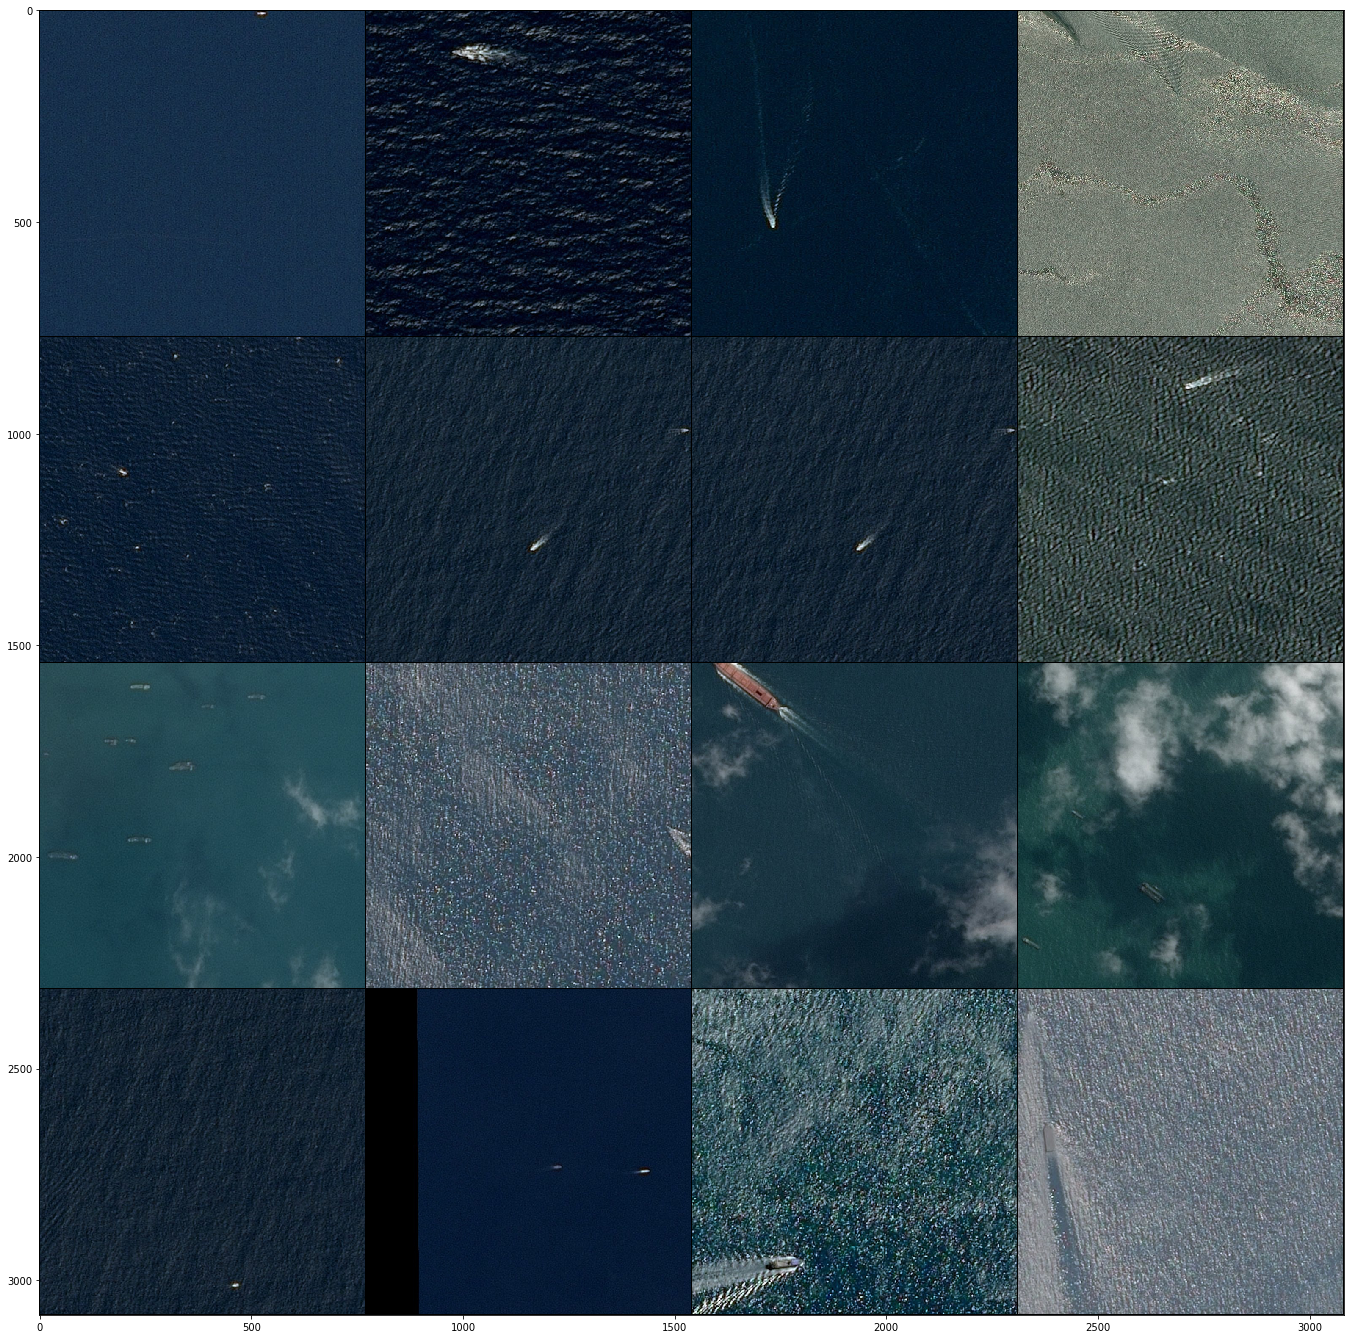

In [15]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

loader = D.DataLoader(lost_ds, batch_size=16, shuffle=True, num_workers=4)

# get some images
dataiter = iter(loader)
images = dataiter.next()
plt.figure(figsize=(24,24))
imshow(torchvision.utils.make_grid(images, nrow=4))

In [6]:
real[real['EncodedPixels']!=-1].count()

ImageId          25693
EncodedPixels    25693
dtype: int64

In [7]:
25693/88486 * 100

29.03623172027213